# Predicting Power Output Using Machine Learning

## 1. Objective
We have information gathered from 2 solar power plants in India over a 34 day period. Each power plant has 2 datasets: 1) power generation and 2) sensor readings. The power generation data is gathered from the inverters, while the sensor readings are gathered from sensors places around the plant.

After analyzing the data to determina which features are most important, we will try to predict the amount of power produced by each plant, based on the given data, using machine learning models.

## 2. Data Information

#### Plant x: Generation Data
- **DATE_TIME**: Date and time for each observation, recorded at 15 minute intervals.

- **PLANT_ID**: ID of the plant. This is obviously common throughout the file for a given plant.

- **SOURCE_KEY**: ID of the inverter. There are multiple inverters in a plant.

- **DC_POWER**: Amount of DC power, in $ kW $, generated by the inverter in the 15 minute interval.

- **AC_POWER**: Amount of AC power, in $ kW $, generated by the ivnerter in the 15 minute interval.

- **DAILY_YIELD**: Cumulative sum of power, in $ kW $, generated by the plant on the given day.

- **TOTAL_YIELD**: Total power generated by the given inverter up until the given point in time.


#### Plant x: Weather Sensor Data
- **DATE_TIME**: Date and time for each observation, recorded at 15 minute intervals.

- **PLANT_ID**: ID of the plant. This is obviously common throughout the file for a given plant.

- **SOURCE_KEY**: ID of the inverter. There are multiple inverters in a plant.

- **AMBIENT_TEMPERATURE**: Ambient temperature, in $ ^\circ C $, at the plant at the given time.

- **MODULE_TEMPERATURE**: Temperature reading of the solar panel attached to the sensor panel at the given time.

- **IRRADIATION**: Amount of irradiation, $ W/m^2 $ for the 15 minute interval.

## 3. Dependencies
Here are all the imports we'll be using to develop a solution to our problem.

- **numpy & pandas**: Helps us easily manipulate the data.

- **matplotlib & seaborn**: Provides a wide variety of plots and graphs to aid in data visualization.

- **sklearn**: Provides all tools necessary to create and evaluate models.

- **datetime**: In case we need to modify the DATE_TIME feature present in all datasets.

- **warnings**: Lets us ignore warnings so output is cleaner.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import scale
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import datetime as dt
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

## 4. Data Cleaning and Analysis

In this section we'll focus on cleaning and analyzing the data so that the models we try can make reliable predictions.

In [2]:
p1_generation = pd.read_csv('./data/Plant_1_Generation_Data.csv')
p1_weather = pd.read_csv('./data/Plant_1_Weather_Sensor_Data.csv')

p2_generation = pd.read_csv('./data/Plant_2_Generation_Data.csv')
p2_weather = pd.read_csv('./data/Plant_2_Weather_Sensor_Data.csv')

dataframe_list = [p1_generation, p1_weather, p2_generation, p2_weather]

In [3]:
p1_generation.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [4]:
p1_weather.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [5]:
print('Plant 1 information')
print('===================')
for dataframe in dataframe_list[:2]:
	print(dataframe.info())
	print('==============')
	print(dataframe.isna().sum())

Plant 1 information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB
None
DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null

In [6]:
print('Plant 2 information')
print('===================')
for dataframe in dataframe_list[2:]:
	print(dataframe.info())
	print('==============')
	print(dataframe.isna().sum())

Plant 2 information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    67698 non-null  object 
 1   PLANT_ID     67698 non-null  int64  
 2   SOURCE_KEY   67698 non-null  object 
 3   DC_POWER     67698 non-null  float64
 4   AC_POWER     67698 non-null  float64
 5   DAILY_YIELD  67698 non-null  float64
 6   TOTAL_YIELD  67698 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.6+ MB
None
DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3259 non-null   object 
 1   PLANT_ID             3259 non-null

In our case, we're lucky because there is no data classified as `NaN` in any of our datasets.

However, we should convert the **DATE_TIME** column from an object to a format that we can easily manipulate later on during analysis.

Lets also merge each plant's data so we can manipulate it easier.

In [7]:
p1_generation['DATE_TIME'] = pd.to_datetime(p1_generation['DATE_TIME'])
p1_weather['DATE_TIME'] = pd.to_datetime(p1_weather['DATE_TIME'])
p2_generation['DATE_TIME'] = pd.to_datetime(p2_generation['DATE_TIME'])
p2_weather['DATE_TIME'] = pd.to_datetime(p2_weather['DATE_TIME'])

plant1 = p1_generation.merge(p1_weather, on='DATE_TIME')
plant1 = plant1.drop(['PLANT_ID_y', 'SOURCE_KEY_y'], axis=1)
plant1['TIME'] = plant1['DATE_TIME'].dt.time

plant2 = p2_generation.merge(p2_weather, on='DATE_TIME')
plant2 = plant2.drop(['PLANT_ID_y', 'SOURCE_KEY_y'], axis=1)
plant2['TIME'] = plant2['DATE_TIME'].dt.time

Let's get some information about the plants themselves, like how many inverters are present, how much energy they produce...

Plant 1 has 22 inverters
Plant 2 has 22 inverters


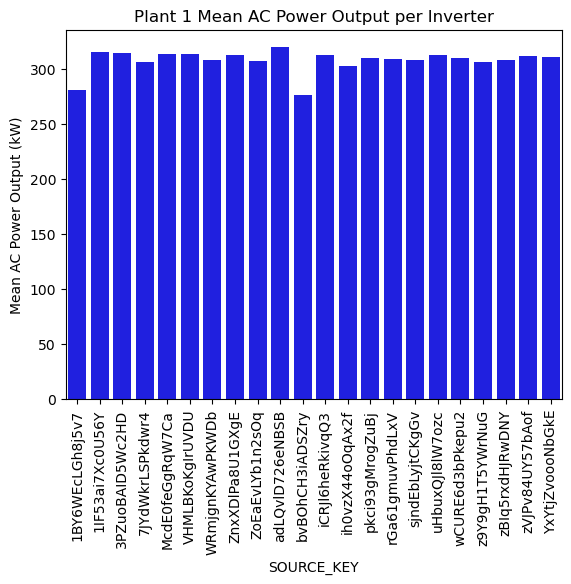

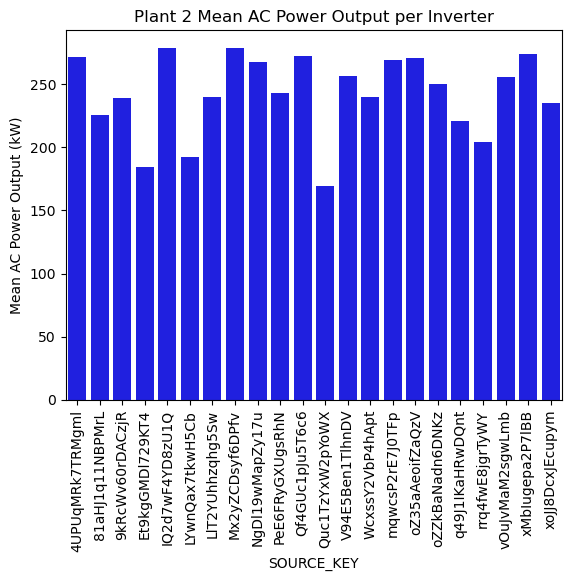

In [8]:
plant1_inverters = p1_generation['SOURCE_KEY'].nunique()
plant2_inverters = p2_generation['SOURCE_KEY'].nunique()
print('Plant 1 has {} inverters\nPlant 2 has {} inverters'.format(plant1_inverters, plant2_inverters))

ax = sns.barplot(data=p1_generation, x='SOURCE_KEY', y='AC_POWER', orient='v', color='blue', ci=None)
ax.set_title('Plant 1 Mean AC Power Output per Inverter')
ax.set(ylabel='Mean AC Power Output (kW)')
ax.set_xticklabels(labels=p1_generation['SOURCE_KEY'].unique(), rotation=90)
plt.show()

ax = sns.barplot(data=p2_generation, x='SOURCE_KEY', y='AC_POWER', orient='v', color='blue', ci=None)
ax.set_title('Plant 2 Mean AC Power Output per Inverter')
ax.set(ylabel='Mean AC Power Output (kW)')
ax.set_xticklabels(labels=p2_generation['SOURCE_KEY'].unique(), rotation=90)
plt.show()

We can see that the inverters in plant 1 are fairly consistent in terms of power output. However, in plant 2, power output fluctuates quite a bit between inverters. There are many possible reasons for this; if this fluctuation proves to be a problem later on, we can analyze it further. For now, we'll just take note of it.

For convenience, we can quantify the fluctuation by calculating the standard deviation of power output per plant.

In [9]:
p1_deviation = p1_generation.groupby('SOURCE_KEY').mean()['AC_POWER'].std()
p2_deviation = p2_generation.groupby('SOURCE_KEY').mean()['AC_POWER'].std()

print('Plant 1 inverters power output standard deviation: {:.3f} kW'.format(p1_deviation))
print('Plant 2 inverters power output standard deviation: {:.3f} kW'.format(p2_deviation))

Plant 1 inverters power output standard deviation: 10.074 kW
Plant 2 inverters power output standard deviation: 32.002 kW


Lets take a look at the correlations so we can get an idea of what the most important features are in the datasets. Intuitively, the most important feature is probably: **IRRADIATION**.

We'll do this using heatmaps. However, heatmaps expect data to be numeric. In our case, instead of encoding the `NaN` values, we can just drop those columns.

In [10]:
plant1_heat = plant1.drop(['PLANT_ID_x', 'SOURCE_KEY_x', 'TIME'], axis=1)
plant2_heat = plant2.drop(['PLANT_ID_x', 'SOURCE_KEY_x', 'TIME'], axis=1)

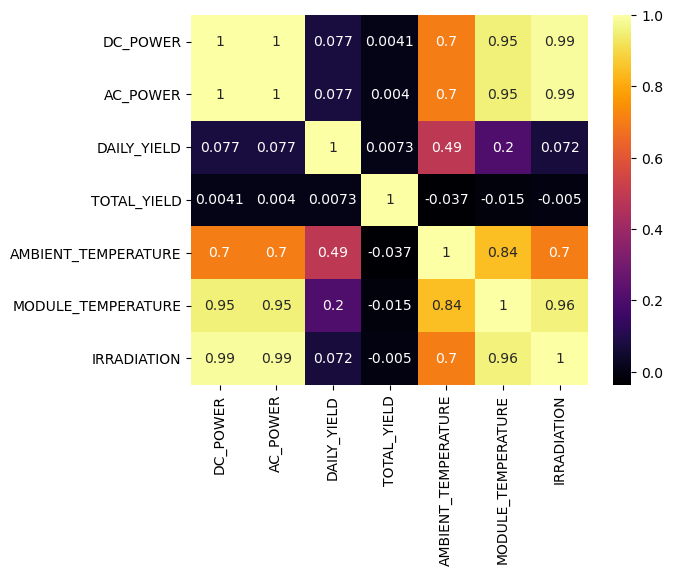

In [11]:
ax = sns.heatmap(plant1_heat.corr(), cmap='inferno', annot=True)

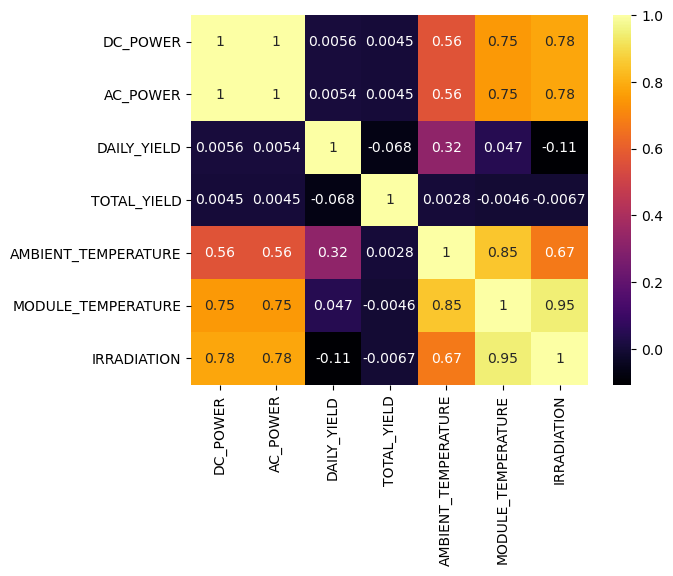

In [12]:
ax = sns.heatmap(plant2_heat.corr(), cmap='inferno', annot=True)

As we can see, output power is highly dependent on the following features:
- **IRRADIATION**
- **MODULE_TEMPERATURE**
- **AMBIENT_TEMPERATURE**

Our hypothesis was partially correct. Now, you may have noticed that there are 2 different output power metrics: **AC_POWER** and **DC_POWER**. So what metric are we going to use in our models and further data analysis?

Well, solar panels are a source of DC power. Inverters are then used to convert the DC power to AC power. The mathematics of how AC power is calculated are not important, and neither is efficiency of the inverters. We want to predict the amount of power that can be generated given one or more of the deciding features (listed above). So, we will only take **DC_POWER** into account in future data analysis and model implementations.

To get more information on the plants and the most important features, lets take a look at them with some graphs.

<AxesSubplot:title={'center':'Plant 2 Irradiation (W/m2) per Day'}, xlabel='DATE_TIME'>

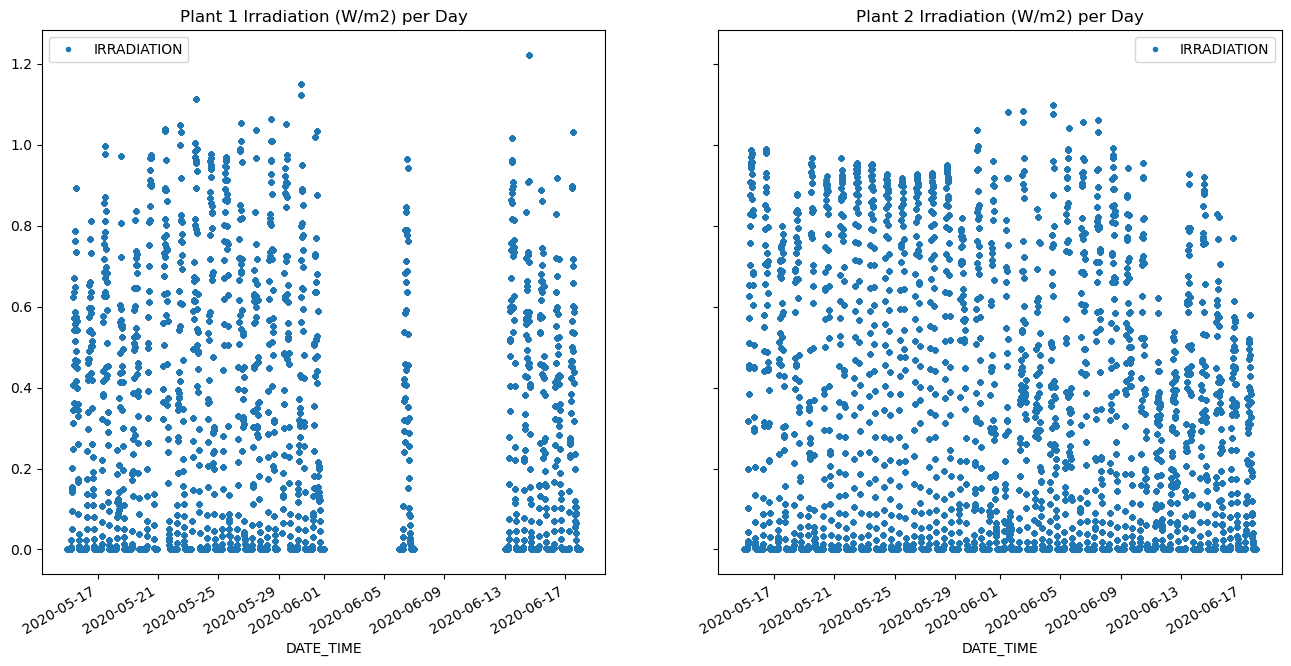

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plant1.plot(x='DATE_TIME', y='IRRADIATION', style='.', title='Plant 1 Irradiation (W/m2) per Day', ax=ax[0])
plant2.plot(x='DATE_TIME', y='IRRADIATION', style='.', title='Plant 2 Irradiation (W/m2) per Day', ax=ax[1])

There seems to be a few days at plant 1 where there was no irradiation, while plant 2 doesn't have this issue. [According to the dataset author, a plant can be shut down on orders from officials](https://www.kaggle.com/datasets/anikannal/solar-power-generation-data/discussion/181235#1061571). So this is probably the explanation for the gap in detected irradiation at plant 1.

Lets take a look at irradiation levels throughout the day. We should expect something like a normal distribution of irradiation throughout the day.

<AxesSubplot:title={'center':'Plant 2 Irradiation (W/m^2) per Hour'}, xlabel='TIME'>

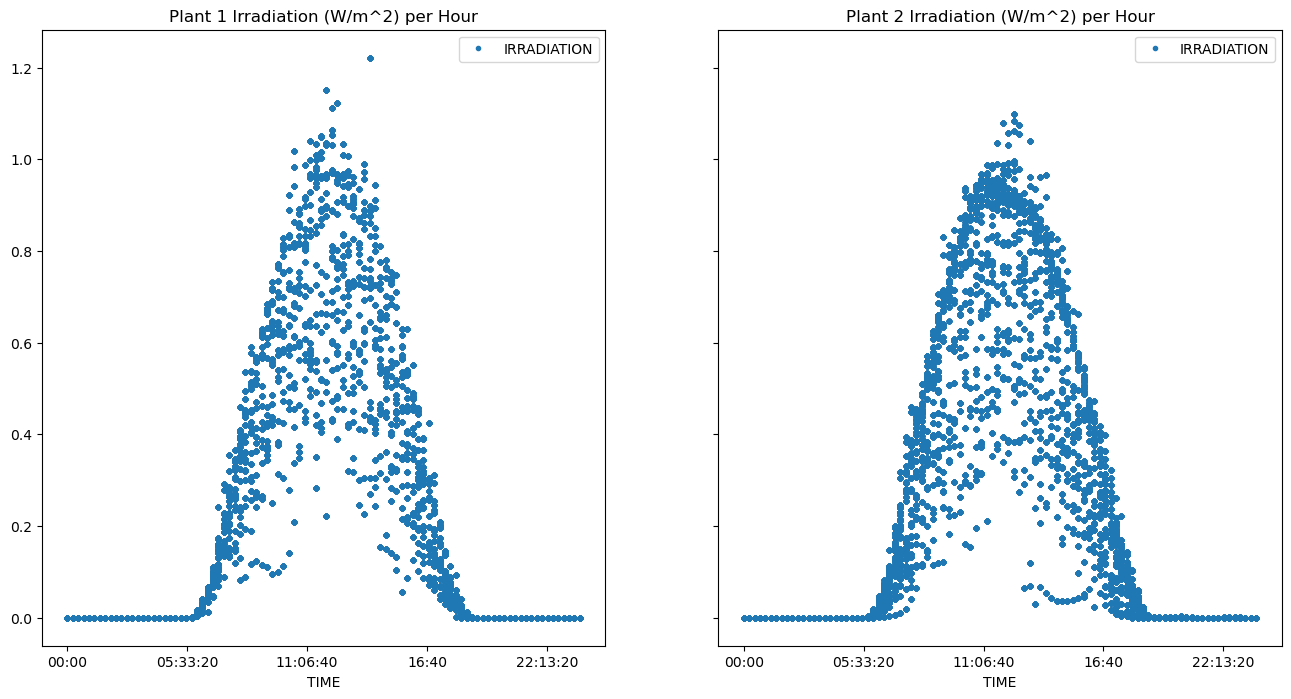

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plant1.plot(x='TIME', y='IRRADIATION', style='.', title='Plant 1 Irradiation (W/m^2) per Hour', ax=ax[0])
plant2.plot(x='TIME', y='IRRADIATION', style='.', title='Plant 2 Irradiation (W/m^2) per Hour', ax=ax[1])

As expected, irradiation levels rise around 05:30 and fall back to `0.0` a bit after 17:00.

Now lets take a look at DC power throughout the day. This should look denser than irradiation throughout the day (previous graphs), yet maintain the same, or at least a similar, structure.

<AxesSubplot:title={'center':'Plant 2 DC Power (kW) per Hour'}, xlabel='TIME'>

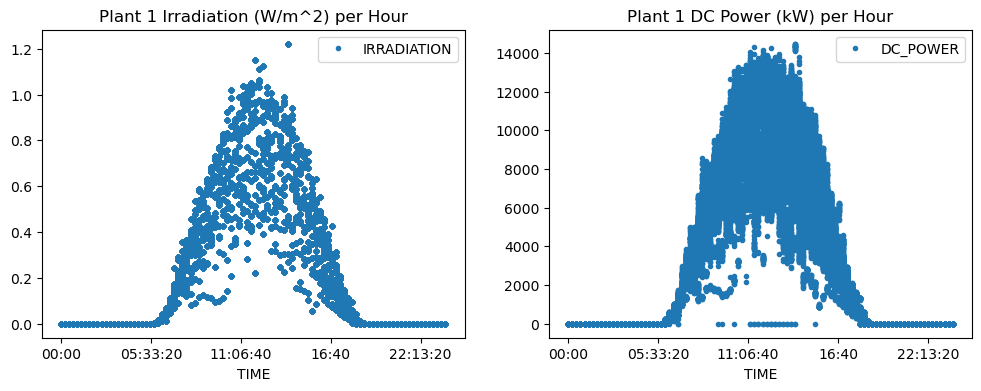

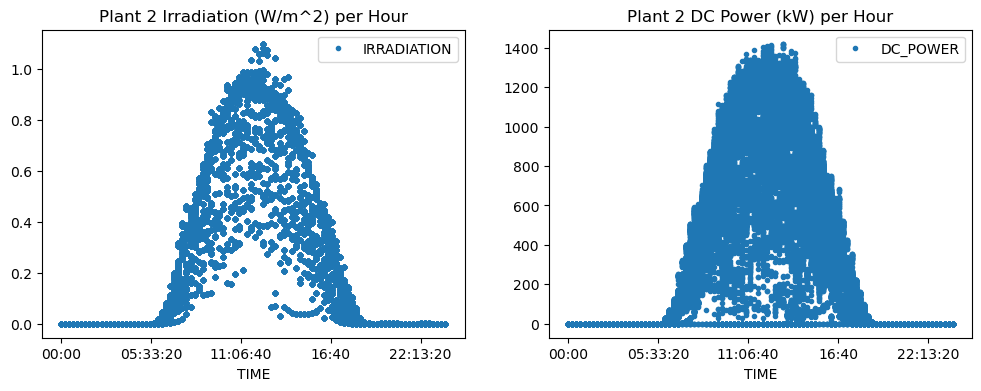

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plant1.plot(x='TIME', y='IRRADIATION', style='.', title='Plant 1 Irradiation (W/m^2) per Hour', ax=ax1)
plant1.plot(x='TIME', y='DC_POWER', style='.', title='Plant 1 DC Power (kW) per Hour', ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plant2.plot(x='TIME', y='IRRADIATION', style='.', title='Plant 2 Irradiation (W/m^2) per Hour', ax=ax1)
plant2.plot(x='TIME', y='DC_POWER', style='.', title='Plant 2 DC Power (kW) per Hour', ax=ax2)

Lets now take a look at the remaining important features in graphs that show their values throughout the day. Intuitively, we'd expect temperatures to rise throughout the day, in a similar fashion to how irradiation was displayed in previous graphs.

<AxesSubplot:title={'center':'Plant 2 Ambient Temperature (C) per Hour'}, xlabel='TIME'>

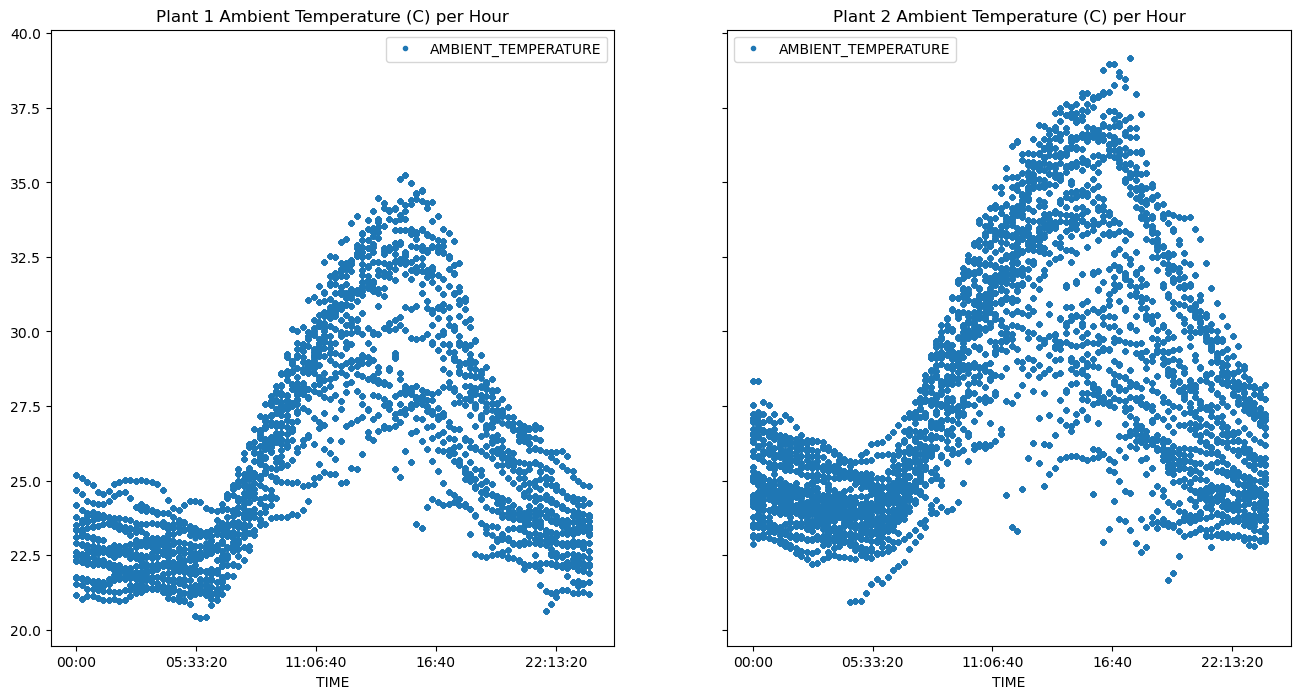

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plant1.plot(x='TIME', y='AMBIENT_TEMPERATURE', style='.', title='Plant 1 Ambient Temperature (C) per Hour', ax=ax[0])
plant2.plot(x='TIME', y='AMBIENT_TEMPERATURE', style='.', title='Plant 2 Ambient Temperature (C) per Hour', ax=ax[1])

<AxesSubplot:title={'center':'Plant 2 Module Temperature (C) per Hour'}, xlabel='TIME'>

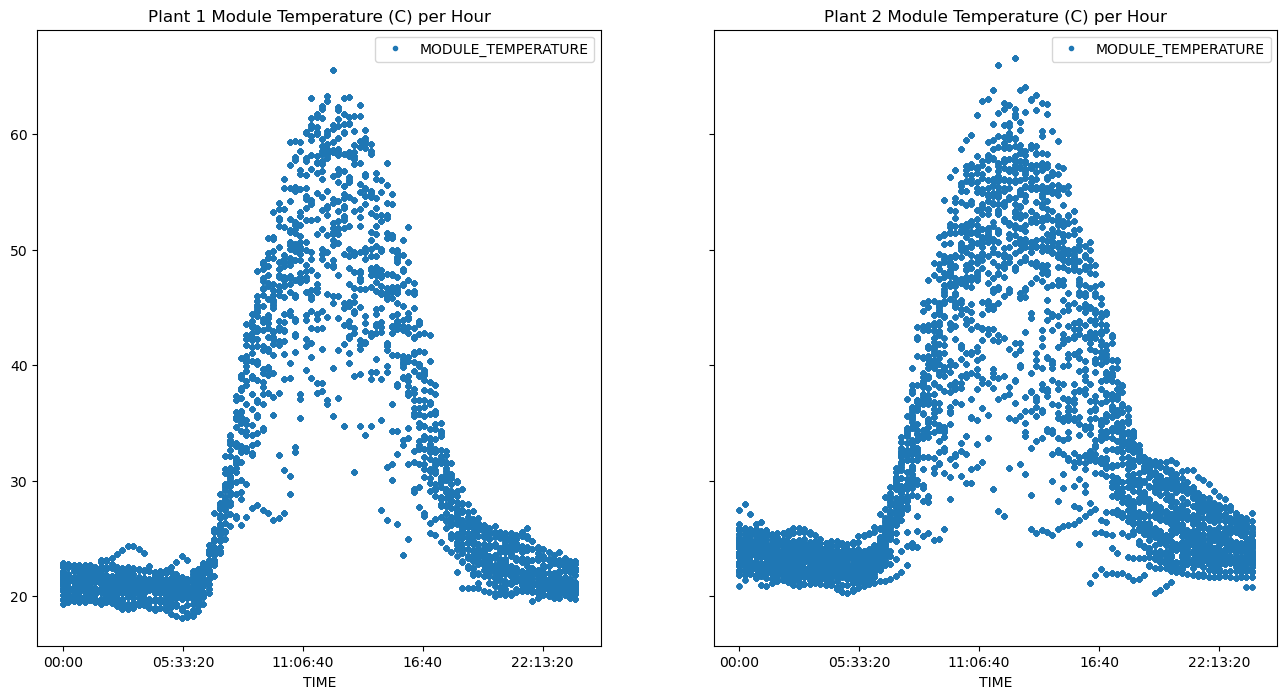

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
plant1.plot(x='TIME', y='MODULE_TEMPERATURE', style='.', title='Plant 1 Module Temperature (C) per Hour', ax=ax[0])
plant2.plot(x='TIME', y='MODULE_TEMPERATURE', style='.', title='Plant 2 Module Temperature (C) per Hour', ax=ax[1])

These graphs don't show anything strange; we can clearly see that temperatures rise around 05:30 and fall later on in the day, as expected.

## 5. Regression Models

In this section, we'll focus on developing and testing some regression models on our datasets. First, we'll drop all the non-relevant features from the datasets, then start with modeling!

In [18]:
plant1 = plant1.drop(['DATE_TIME', 'PLANT_ID_x', 'SOURCE_KEY_x', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'TIME'], axis=1)
plant2 = plant2.drop(['DATE_TIME', 'PLANT_ID_x', 'SOURCE_KEY_x', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'TIME'], axis=1)

In [19]:
column_list = list(plant1.columns)
length_features = len(list(plant1.columns))

x1 = plant1[column_list[1:length_features]]
y1 = plant1[column_list[0]]

x2 = plant2[column_list[1:length_features]]
y2 = plant2[column_list[0]]

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=123)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.3, random_state=123)

We'll start with a simple linear regression model on the most important features we previously identified. This will give us an idea of how large of a deciding factor each of these features are in determining DC power. It's best to start out simple and add complexity if needed.

#### Linear Regression - Ambient Temperature (Univariate)

R^2 score for Plant 1 model: 0.495
R^2 score for Plant 2 model: 0.317


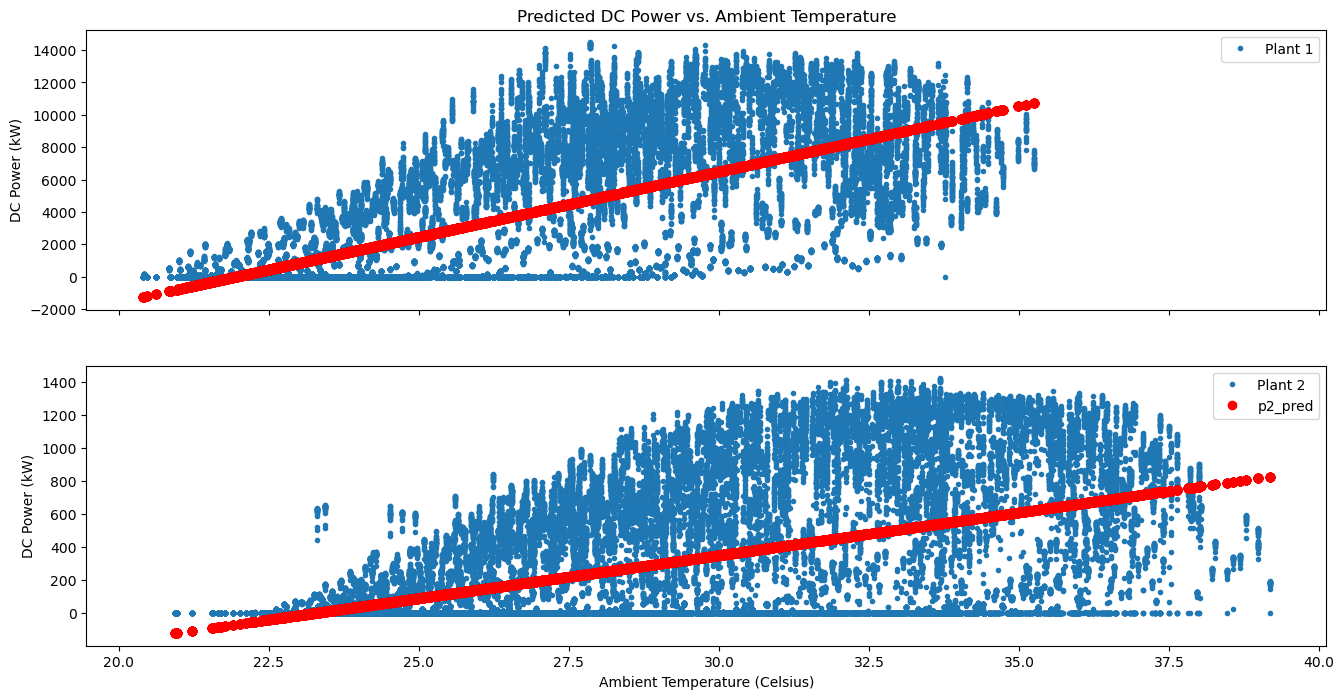

In [20]:
lreg_plant1_at = LinearRegression()
lreg_plant2_at = LinearRegression()
lreg_plant1_at.fit(plant1['AMBIENT_TEMPERATURE'].values.reshape(-1, 1), plant1['DC_POWER'])
lreg_plant2_at.fit(plant2['AMBIENT_TEMPERATURE'].values.reshape(-1, 1), plant2['DC_POWER'])

p1_pred_at = lreg_plant1_at.predict(plant1['AMBIENT_TEMPERATURE'].values.reshape(-1, 1))
p2_pred_at = lreg_plant2_at.predict(plant2['AMBIENT_TEMPERATURE'].values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
plant1.plot(x='AMBIENT_TEMPERATURE', y='DC_POWER', style='.', label='Plant 1', ax=axs[0])
plant2.plot(x='AMBIENT_TEMPERATURE', y='DC_POWER', style='.', label='Plant 2', ax=axs[1])
axs[0].plot(plant1['AMBIENT_TEMPERATURE'], p1_pred_at, 'ro', label='p1_pred')
axs[1].plot(plant2['AMBIENT_TEMPERATURE'], p2_pred_at, 'ro', label='p2_pred')
axs[1].set_xlabel('Ambient Temperature (Celsius)')
axs[0].set_title('Predicted DC Power vs. Ambient Temperature')
axs[0].set_ylabel('DC Power (kW)')
axs[1].set_ylabel('DC Power (kW)')
plt.legend()

print('R^2 score for Plant 1 model: {:.3f}'.format(r2_score(plant1['DC_POWER'], p1_pred_at)))
print('R^2 score for Plant 2 model: {:.3f}'.format(r2_score(plant2['DC_POWER'], p2_pred_at)))

As expected, in accordance with the correlation conclusions we discovered previously, ambient temperature is, by itself, not a good indicator of DC power. This makes sense, as solar panels couldn't care less about the ambient temperature.

#### Linear Regression - Module Temperature (Univariate)

R^2 score for Plant 1 model: 0.911
R^2 score for Plant 2 model: 0.562


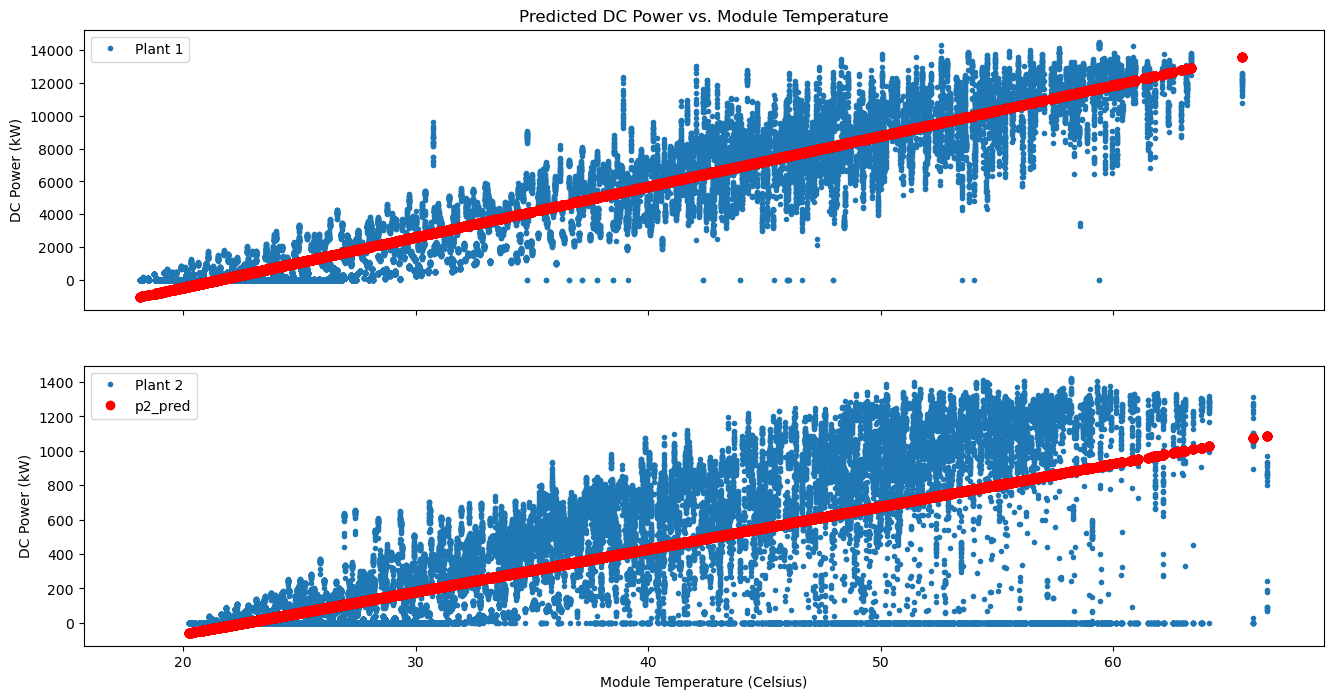

In [21]:
lreg_plant1_mt = LinearRegression()
lreg_plant2_mt = LinearRegression()
lreg_plant1_mt.fit(plant1['MODULE_TEMPERATURE'].values.reshape(-1, 1), plant1['DC_POWER'])
lreg_plant2_mt.fit(plant2['MODULE_TEMPERATURE'].values.reshape(-1, 1), plant2['DC_POWER'])

p1_pred_mt = lreg_plant1_mt.predict(plant1['MODULE_TEMPERATURE'].values.reshape(-1, 1))
p2_pred_mt = lreg_plant2_mt.predict(plant2['MODULE_TEMPERATURE'].values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
plant1.plot(x='MODULE_TEMPERATURE', y='DC_POWER', style='.', label='Plant 1', ax=axs[0])
plant2.plot(x='MODULE_TEMPERATURE', y='DC_POWER', style='.', label='Plant 2', ax=axs[1])
axs[0].plot(plant1['MODULE_TEMPERATURE'], p1_pred_mt, 'ro', label='p1_pred')
axs[1].plot(plant2['MODULE_TEMPERATURE'], p2_pred_mt, 'ro', label='p2_pred')
axs[1].set_xlabel('Module Temperature (Celsius)')
axs[0].set_title('Predicted DC Power vs. Module Temperature')
axs[0].set_ylabel('DC Power (kW)')
axs[1].set_ylabel('DC Power (kW)')
plt.legend()

print('R^2 score for Plant 1 model: {:.3f}'.format(r2_score(plant1['DC_POWER'], p1_pred_mt)))
print('R^2 score for Plant 2 model: {:.3f}'.format(r2_score(plant2['DC_POWER'], p2_pred_mt)))

Again, in line witho our conclusions, we can see that the module temperature is a definite deciding factor of DC power. However, before moving on, lets analyze this feature a bit more. Why is it that module temperature is much more important that ambient temperature, another measurement of temperature? We stated previously that ambient temperature has, in our case, little to no impact on the solar panel's ability to produce power.

Well, module temperature, in this case, is actually closely related to irradiation (which we know is the deciding factor of power output). As stated in section 2, module temperature is a measurement of the temperature of the solar panel that the sensor panel is attached to. It stands to reason that, with more irradiance, the hotter the receiving object (the solar panel) will become.

So it turns out that module temperature has a direct relationship with irradiance. It's not of much importance to us now, but it is something we should keep in mind.

#### Linear Regression - Irradiation (Univariate)

R^2 score for Plant 1 model: 0.983
R^2 score for Plant 2 model: 0.610


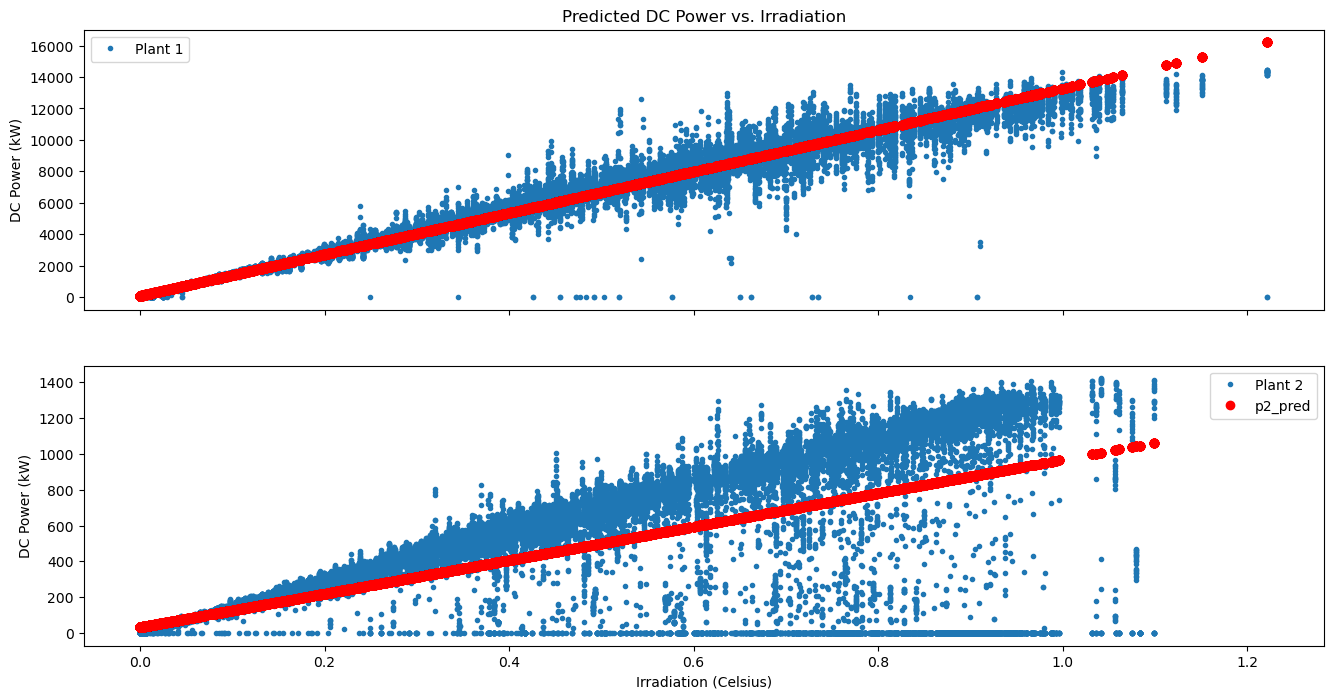

In [22]:
lreg_plant1_ir = LinearRegression()
lreg_plant2_ir = LinearRegression()
lreg_plant1_ir.fit(plant1['IRRADIATION'].values.reshape(-1, 1), plant1['DC_POWER'])
lreg_plant2_ir.fit(plant2['IRRADIATION'].values.reshape(-1, 1), plant2['DC_POWER'])

p1_pred_ir = lreg_plant1_ir.predict(plant1['IRRADIATION'].values.reshape(-1, 1))
p2_pred_ir = lreg_plant2_ir.predict(plant2['IRRADIATION'].values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
plant1.plot(x='IRRADIATION', y='DC_POWER', style='.', label='Plant 1', ax=axs[0])
plant2.plot(x='IRRADIATION', y='DC_POWER', style='.', label='Plant 2', ax=axs[1])
axs[0].plot(plant1['IRRADIATION'], p1_pred_ir, 'ro', label='p1_pred')
axs[1].plot(plant2['IRRADIATION'], p2_pred_ir, 'ro', label='p2_pred')
axs[1].set_xlabel('Irradiation (Celsius)')
axs[0].set_title('Predicted DC Power vs. Irradiation')
axs[0].set_ylabel('DC Power (kW)')
axs[1].set_ylabel('DC Power (kW)')
plt.legend()

print('R^2 score for Plant 1 model: {:.3f}'.format(r2_score(plant1['DC_POWER'], p1_pred_ir)))
print('R^2 score for Plant 2 model: {:.3f}'.format(r2_score(plant2['DC_POWER'], p2_pred_ir)))

Of course, predicting DC power output based on irradiance will give the best results. This makes sense and basically just proves to us that the solar panels are functioning normally.

One thing to note however, are the second plant's results. As we can see, although the $ R^2 $ score for each of the plants increases up to their maximum values (using univariate models), plant 2's score remains low.

From this point on, we'll be trying different models on both plants with the goal of increasing plant 2's score.

#### Linear Regression (Multivariate)

In [23]:
p1_lr = LinearRegression()
p1_lr.fit(x1_train, y1_train)
p1_lr_pred = p1_lr.predict(x1_test)

p2_lr = LinearRegression()
p2_lr.fit(x2_train, y2_train)
p2_lr_pred = p2_lr.predict(x2_test)

In [24]:
print('R^2 score for Plant 1 model: {:.3f}'.format(r2_score(y1_test, p1_lr_pred)))
print('R^2 score for Plant 2 model: {:.3f}'.format(r2_score(y2_test, p2_lr_pred)))

R^2 score for Plant 1 model: 0.983
R^2 score for Plant 2 model: 0.615


Multivariate linear regression barely makes a difference; plant 2's $ R^2 $ score increases by `0.005`, while plant 1's $ R^2 $ score remains the same.

#### Huber Regression (Multivariate)

In [25]:
p1_hr = HuberRegressor()
p1_hr.fit(x1_train, y1_train)
p1_hr_pred = p1_hr.predict(x1_test)

p2_hr = HuberRegressor()
p2_hr.fit(x2_train, y2_train)
p2_hr_pred = p2_hr.predict(x2_test)

In [26]:
print('R^2 score for Plant 1 model: {:.3f}'.format(r2_score(y1_test, p1_hr_pred)))
print('R^2 score for Plant 2 model: {:.3f}'.format(r2_score(y2_test, p2_hr_pred)))

R^2 score for Plant 1 model: 0.983
R^2 score for Plant 2 model: 0.469


We tried using the Huber regression technique to no avail. In fact, the $ R^2 $ score for plant 2 is even worse than before.

#### Decision Tree Regressor (Multivariate)

In [27]:
p1_dtr = DecisionTreeRegressor()
p1_dtr.fit(x1_train, y1_train)
p1_dtr_pred = p1_dtr.predict(x1_test)

p2_dtr = DecisionTreeRegressor()
p2_dtr.fit(x2_train, y2_train)
p2_dtr_pred = p2_dtr.predict(x2_test)

In [28]:
print('R^2 score for Plant 1 model: {:.3f}'.format(r2_score(y1_test, p1_dtr_pred)))
print('R^2 score for Plant 2 model: {:.3f}'.format(r2_score(y2_test, p2_dtr_pred)))

R^2 score for Plant 1 model: 0.989
R^2 score for Plant 2 model: 0.667


As we can see from the previous models, the $ R^2 $ score for plant 2 hasn't really improved. It has been improved slightly, but nothing major.

It's possible we might need to clean up plant 2's dataset a bit more; in particular, apply outlier removal. [There are many different way to apply outlier removal](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/). We'll go with **Interquartile Range** removal.

## 6. Outlier Removal

The IQR of a dataset is the difference between the `75%` and `25%` percentiles of the data. We can use the IQR to identify outliers by simply dropping values that are a factor `k` of the IQR range otuside of the `25%` or `75%` percentile range. `k` is usually `1.5`.

In [29]:
k = 1.5
q1 = np.percentile(plant2['DC_POWER'], 25)
q3 = np.percentile(plant2['DC_POWER'], 75)
iqr = q3 - q1

outlier_locations = np.where(plant2['DC_POWER'] > (q3 + k * iqr))
print('There are approximately {} outliers according to the IQR outlier removal technique.'.format(len(outlier_locations[0])))

There are approximately 3079 outliers according to the IQR outlier removal technique.


In [30]:
plant2_no_outliers = plant2.drop(outlier_locations[0], axis=0)

column_list = list(plant2_no_outliers.columns)
length_features = len(list(plant2_no_outliers.columns))

x3 = plant2_no_outliers[column_list[1:length_features]]
y3 = plant2_no_outliers[column_list[0]]

x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.3, random_state=123)

Now that we've removed the outliers, let's try running our models again and see if the $ R^2 $ score improves!

## 7. Rerunning Model with Outliers Removed

We'll use the best model we have so far, which is the multivariate implementation of the **Decision Tree Regressor**.

In [31]:
p2_dtr_v2 = DecisionTreeRegressor()
p2_dtr_v2.fit(x3_train, y3_train)
p2_dtr_pred_v2 = p2_dtr_v2.predict(x3_test)

In [32]:
print('R^2 score for Plant 2 model v2: {:.3f}'.format(r2_score(y3_test, p2_dtr_pred_v2)))

R^2 score for Plant 2 model v2: 0.755


As we can see, the $ R^2 $ score for plant 2 has been improved significantly; up by ~10% from the previous best model!

## 8. Conclusions

Here are the conclusions we can extract from our dataset:
- Although both plants have the same amount of inverters, plant 1 is more stable than plant 2 in terms of power output.

- As a result, power output at plant 2 is more difficult to predict.

- The cause of the unstableness of power output at plant 2 is unknown. It would probably be worth the investment to clean and/or replace the sensors, after which, if gathered data continues to behave erratically, replace the solar panel itself.

- Plant 2 is in a warmer location than plant 1. This is evident from the graphs of ambient temperature per hour; the ambient temperature in plant 2 is consistently ~10% higher than that of plant 1.

- The dataset is quite small; we only have data gathered over a 1 month period. This is not exactly ideal and has at least two negative implications:
  - The models will most likely fail when used with data gathered from other seasons. Because the dataset is only from a 1 month period during summer, we cannot expect the model to perform well in fall, spring, or winter.
  - The models we can use are limited; we can't use anything like deep learning models or neural networks. If we had more data, we'd be able to test out other models that rely on large amounts of data to work properly.